In [1]:
import os
from pathlib import Path

# 方法 1：相對於 notebook 位置
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent  # 從 model/aapl 往上兩層
os.chdir(project_root)

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import numpy as np
import ta

In [3]:
df = pd.read_csv("data/AAPL.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[23:]
df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
stoch = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'], window=14)
df['k'] = stoch.stoch()
df['d'] = stoch.stoch_signal()
df

,Close,High,Low,Open,Volume,rsi,k,d
Date,,,,,,,,
2014-01-06,16.871346,16.960365,16.550935,16.670353,412610800,NaN,NaN,NaN
2014-01-07,16.750681,16.934304,16.684924,16.883435,317209200,NaN,NaN,NaN
2014-01-08,16.856766,16.921901,16.708813,16.712533,258529600,NaN,NaN,NaN
2014-01-09,16.641502,16.962223,16.605212,16.960361,279148800,NaN,NaN,NaN
2014-01-10,16.530458,16.774256,16.473696,16.744168,304976000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-12-22,191.788773,193.581837,191.164662,193.353978,37149600,54.672823,36.229135,52.092899
2023-12-26,191.243927,192.076065,191.025984,191.798686,28919300,53.090083,19.878370,38.505327
2023-12-27,191.342941,191.689673,189.302216,190.689128,48087700,53.354360,24.149983,26.752496


In [4]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(data_trend, train_ratio, n_past, predict_day):
    scaler = MinMaxScaler()  
    print(data_trend.shape)
    data_trend = scaler.fit_transform(data_trend)
    
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day, 0])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data = df[[c for c in df.columns if c not in ['Date','Volume','rsi','k','d']]].values
train_ratio = 0.9
test_val_ratio = 0.9
n_past = 40     #移動視窗大小
predict_day = 5 #要預測後面幾天
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = preprocess(data, train_ratio, n_past, predict_day)
batch_size = 32

train_set = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

val_set = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)




(2514, 4)


In [5]:

class BiLSTM(nn.Module):
    def __init__(self, n_features, hidden_dim, predict_day):
        super(BiLSTM, self).__init__()
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.predict_day = predict_day
        
        self.lstm = nn.LSTM(input_size=self.n_features, hidden_size=self.hidden_dim, 
                            num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(self.hidden_dim * 2, self.predict_day)
        
    def forward(self, x): 
        x, _ = self.lstm(x)
        x = self.linear(x[:,-1,:]) #取最後一個state
        
        return x


In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# 檢查是否有可用的GPU
if torch.cuda.is_available():
    print("GPU")
    device = torch.device("cuda")  # 使用GPU
else:
    print("CPU")
    device = torch.device("cpu")  # 使用CPU
# 設置訓練參數
num_epochs = 100
learning_rate = 0.001

# 初始化模型、損失函數和優化器
model = BiLSTM(n_features=4, hidden_dim=128, predict_day=5)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

GPU


In [7]:
# 記錄每個 epoch 的損失值
train_losses = []
val_losses = []
min_val_loss = float('inf')
best_model_path = "output/model/aapl/bilstm_5.pth"

# 訓練模型
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch= x_batch.to(device)
        y_batch= y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # 驗證模型
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch= x_batch.to(device)
            y_batch= y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    '''
    if val_loss < min_val_loss and epoch>50:
        min_val_loss = val_loss
        torch.save(model, best_model_path) 
        print(f"Model saved with val_loss: {val_loss:.4f}")
    '''
    # 打印每個epoch的訓練和驗證損失
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    torch.save(model, best_model_path)



Epoch [1/100], Train Loss: 0.0024, Val Loss: 0.0037
Epoch [2/100], Train Loss: 0.0213, Val Loss: 0.0045
Epoch [3/100], Train Loss: 0.0484, Val Loss: 0.0059
Epoch [4/100], Train Loss: 0.0398, Val Loss: 0.0119
Epoch [5/100], Train Loss: 0.0102, Val Loss: 0.0036
Epoch [6/100], Train Loss: 0.0009, Val Loss: 0.0009
Epoch [7/100], Train Loss: 0.0015, Val Loss: 0.0006
Epoch [8/100], Train Loss: 0.0009, Val Loss: 0.0005
Epoch [9/100], Train Loss: 0.0007, Val Loss: 0.0012
Epoch [10/100], Train Loss: 0.0008, Val Loss: 0.0015
Epoch [11/100], Train Loss: 0.0007, Val Loss: 0.0017
Epoch [12/100], Train Loss: 0.0007, Val Loss: 0.0020
Epoch [13/100], Train Loss: 0.0007, Val Loss: 0.0017
Epoch [14/100], Train Loss: 0.0006, Val Loss: 0.0016
Epoch [15/100], Train Loss: 0.0006, Val Loss: 0.0016
Epoch [16/100], Train Loss: 0.0005, Val Loss: 0.0013
Epoch [17/100], Train Loss: 0.0005, Val Loss: 0.0009
Epoch [18/100], Train Loss: 0.0006, Val Loss: 0.0019
Epoch [19/100], Train Loss: 0.0005, Val Loss: 0.0014
Ep

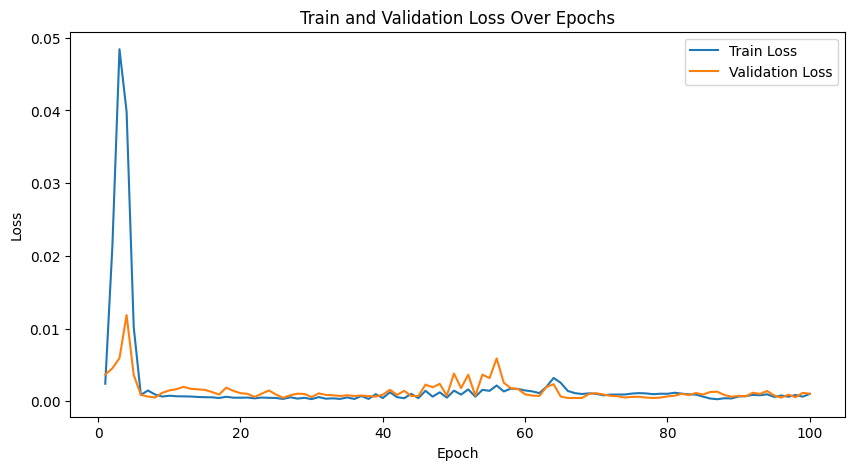

In [8]:
import matplotlib.pyplot as plt
# 繪製損失走勢圖
plt.figure(figsize=(10, 5))
plt.plot(range(1, 100+1), train_losses, label='Train Loss')
plt.plot(range(1, 100+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.show()

In [9]:
import matplotlib.pyplot as plt
print(len(Y_test))
close_price_true = []
temp_real = []
real = Y_test.detach().cpu().numpy()
for i in range(len(Y_test)):
   temp_real.append(real[i][0])
temp_real = np.array(temp_real)
print(temp_real.shape)
temp_real = temp_real.reshape(-1, 1)
temp_real = np.repeat(temp_real, 4, axis=1)
# print(close_price_true)
temp_real = scaler.inverse_transform(temp_real)
# print(temp_real)
for i in range(len(temp_real)):
   close_price_true.append(temp_real[i][0])
print(close_price_true)


208
(208,)
[np.float32(145.44092), np.float32(143.36897), np.float32(143.96094), np.float32(149.01256), np.float32(151.77518), np.float32(149.57495), np.float32(150.82799), np.float32(148.57841), np.float32(146.51634), np.float32(148.46005), np.float32(150.55173), np.float32(150.94635), np.float32(153.76819), np.float32(152.92952), np.float32(155.29747), np.float32(157.15236), np.float32(155.72173), np.float32(156.80702), np.float32(158.1094), np.float32(156.16571), np.float32(155.5441), np.float32(158.62245), np.float32(160.19124), np.float32(162.69728), np.float32(163.95032), np.float32(163.41754), np.float32(161.57254), np.float32(162.46048), np.float32(159.86562), np.float32(158.65207), np.float32(157.96141), np.float32(163.34848), np.float32(163.00319), np.float32(163.02287), np.float32(164.24629), np.float32(165.39085), np.float32(164.42389), np.float32(162.81567), np.float32(163.12154), np.float32(161.58238), np.float32(161.57254), np.float32(166.16042), np.float32(167.41344), n

C:\Users\N98141062\AppData\Local\Temp\ipykernel_12040\1381034729.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('output/model/aapl/bilstm_5.pth')


[np.float32(145.08113), np.float32(144.62776), np.float32(143.14992), np.float32(142.28024), np.float32(145.6667), np.float32(149.90128), np.float32(148.66783), np.float32(148.94736), np.float32(148.69559), np.float32(146.37476), np.float32(146.72452), np.float32(148.4736), np.float32(148.52658), np.float32(150.37575), np.float32(151.81491), np.float32(152.53993), np.float32(154.44215), np.float32(155.67564), np.float32(156.01773), np.float32(156.41144), np.float32(156.57161), np.float32(155.45285), np.float32(157.66388), np.float32(159.31026), np.float32(160.77159), np.float32(162.34933), np.float32(163.22241), np.float32(161.77777), np.float32(161.73386), np.float32(160.24393), np.float32(160.31683), np.float32(159.8084), np.float32(161.92981), np.float32(163.02629), np.float32(163.03587), np.float32(164.23001), np.float32(164.62689), np.float32(164.51178), np.float32(163.6413), np.float32(163.48044), np.float32(163.35193), np.float32(162.61958), np.float32(164.92932), np.float32(166

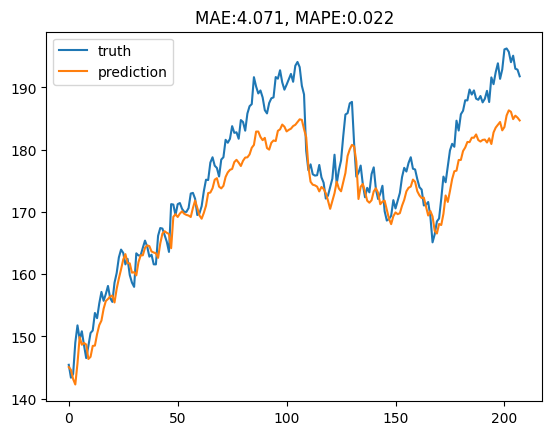

In [10]:
from sklearn.metrics import r2_score
close_price_pred = []
model = torch.load('output/model/aapl/bilstm_5.pth')
model.to(device)
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device))
    pred = pred.detach().cpu().numpy()[0]
    pred = pred.reshape(-1, 1)
    # print(pred)
    pred = np.repeat(pred, 4, axis=1)
    pred_inver = scaler.inverse_transform(pred)
    # print(pred_inver[0][0])
    close_price_pred.append(pred_inver[0][0])
print(close_price_pred)
mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
# 新增：RMSE
rmse = np.sqrt(np.mean((np.array(close_price_true) - np.array(close_price_pred)) ** 2))
# 新增：R²
r2 = r2_score(close_price_true, close_price_pred)
plt.plot(close_price_true)
plt.plot(close_price_pred)
plt.title('MAE:{:.3f}, MAPE:{:.3f}'.format(mae, mape))
plt.legend(['truth', 'prediction'])
# 輸出所有指標
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R²:   {r2:.4f}")

In [11]:
btdf = pd.DataFrame({'close':close_price_true, 'rsi':df['rsi'][-213:-5],'predicted_close':close_price_pred})

In [12]:
btdf =btdf.dropna().reset_index(drop=True)

In [13]:
btdf

,close,rsi,predicted_close
0,145.440918,51.156447,145.081131
1,143.368973,50.113127,144.627762
2,143.960938,45.956782,143.149918
3,149.012558,47.301589,142.280243
4,151.775177,57.109919,145.666702
...,...,...,...
203,194.057312,67.991817,186.081604
204,195.097504,62.680133,184.910324
205,193.007248,64.544443,185.461487
206,192.858658,58.247505,185.156433


買入價格: 146.51634
賣出價格: 148.46005
cash: 1.0132658e+06
額外要扣掉: 4388.8027
扣掉後的: 1.008877e+06
-------------------------------------
買入價格: 155.5441
賣出價格: 158.62245
cash: 1.02884325e+06
額外要扣掉: 4447.016
扣掉後的: 1.02439625e+06
-------------------------------------
買入價格: 162.46048
賣出價格: 159.86562
cash: 1.0080356e+06
額外要扣掉: 4408.2686
扣掉後的: 1.0036274e+06
-------------------------------------
買入價格: 158.65207
賣出價格: 163.00319
cash: 1.03114825e+06
額外要扣掉: 4446.278
扣掉後的: 1.026702e+06
-------------------------------------
買入價格: 163.02287
賣出價格: 165.39085
cash: 1.0416132e+06
額外要扣掉: 4509.769
扣掉後的: 1.03710344e+06
-------------------------------------
買入價格: 162.81567
賣出價格: 167.41344
cash: 1.0663865e+06
額外要扣掉: 4597.0527
扣掉後的: 1.0617895e+06
-------------------------------------
買入價格: 165.21323
賣出價格: 171.18242
cash: 1.1001475e+06
額外要扣掉: 4730.9814
扣掉後的: 1.0954165e+06
-------------------------------------
買入價格: 168.61337
賣出價格: 169.38507
cash: 1.1004294e+06
額外要扣掉: 4779.7246
扣掉後的: 1.0956496e+06
------------------------

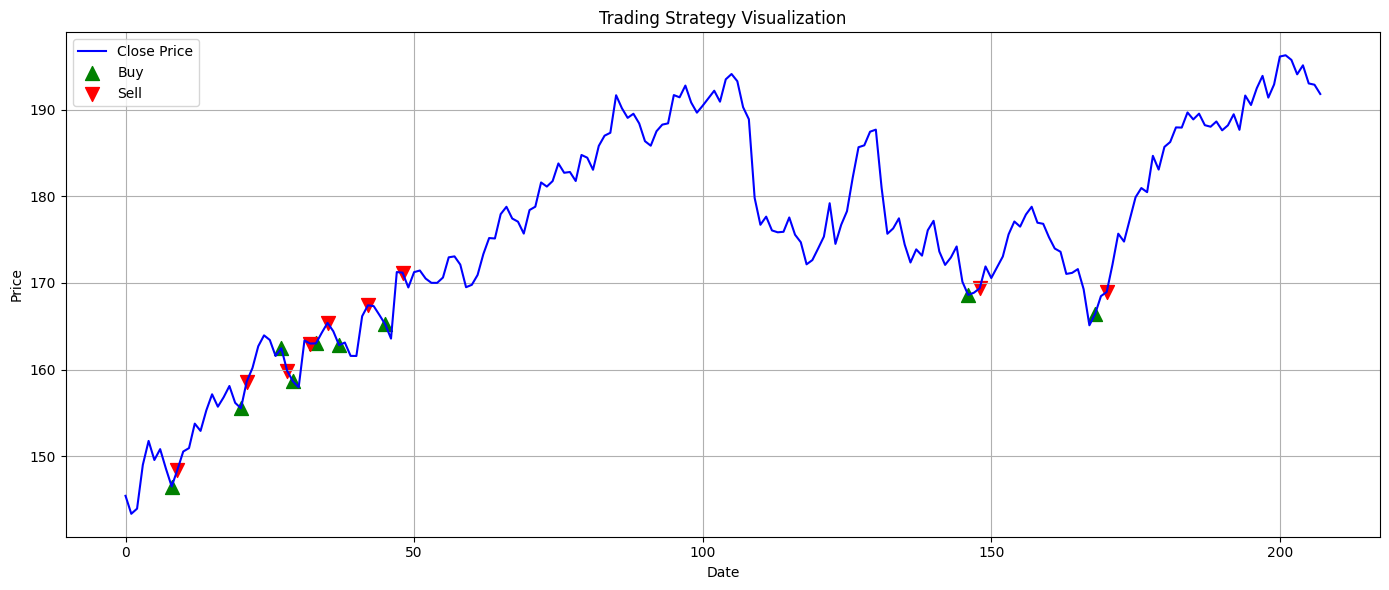

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# 初始化參數
initial_cash = 1000000
in_position = False
entry_price = 0
shares = 0
cash = initial_cash

# 儲存交易點資訊
buy_dates = []
buy_prices = []
sell_dates = []
sell_prices = []

# 手續費和稅率
fee_rate = 0.001425  # 手續費率 (1.425‰)
tax_rate = 0.0015     # 證券交易稅率 (1‰)
need_pay = 0 #需要付的手續費+稅金

# 模擬交易
for i in range(1, len(btdf)):
    if not in_position:
        need_pay = 0
        if btdf.loc[i, 'predicted_close'] > btdf.loc[i - 1, 'close']:
            entry_price = btdf.loc[i, 'close']
            shares = cash // entry_price
            need_pay += cash * fee_rate
            cash -= shares * entry_price
            in_position = True

            buy_dates.append(btdf.index[i])
            buy_prices.append(entry_price)

            print('買入價格:', entry_price)

    else:
        if btdf.loc[i, 'predicted_close'] < btdf.loc[i - 1, 'close']:
            exit_price = btdf.loc[i, 'close']
            cash += shares * exit_price
            need_pay += cash * (fee_rate + tax_rate)
            shares = 0
            in_position = False

            sell_dates.append(btdf.index[i])
            sell_prices.append(exit_price)

            print('賣出價格:', exit_price)
            print('cash:', cash)
            print('額外要扣掉:', need_pay)
            cash -= need_pay
            print('扣掉後的:', cash)
            print('-------------------------------------')

# 最後一天強制平倉
if in_position:
    final_price = btdf.loc[len(btdf) - 1, 'close']
    cash += shares * final_price
    sell_dates.append(btdf.index[-1])
    sell_prices.append(final_price)
    print('賣出價格:', final_price)

# 顯示最終資金
print('最終價格:', cash)

# 繪圖
plt.figure(figsize=(14, 6))
plt.plot(btdf.index, btdf['close'], label='Close Price', color='blue')

# 標記買進與賣出點
plt.scatter(buy_dates, buy_prices, color='green', label='Buy', marker='^', s=100)
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

plt.title('Trading Strategy Visualization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


買入價格: 146.51634
賣出價格: 190.15178
cash: 1.2978118e+06
額外要扣掉: 5221.0996
扣掉後的: 1.2925906e+06
-------------------------------------
買入價格: 168.61337
賣出價格: 191.78876
最終價格: 1.4702531e+06


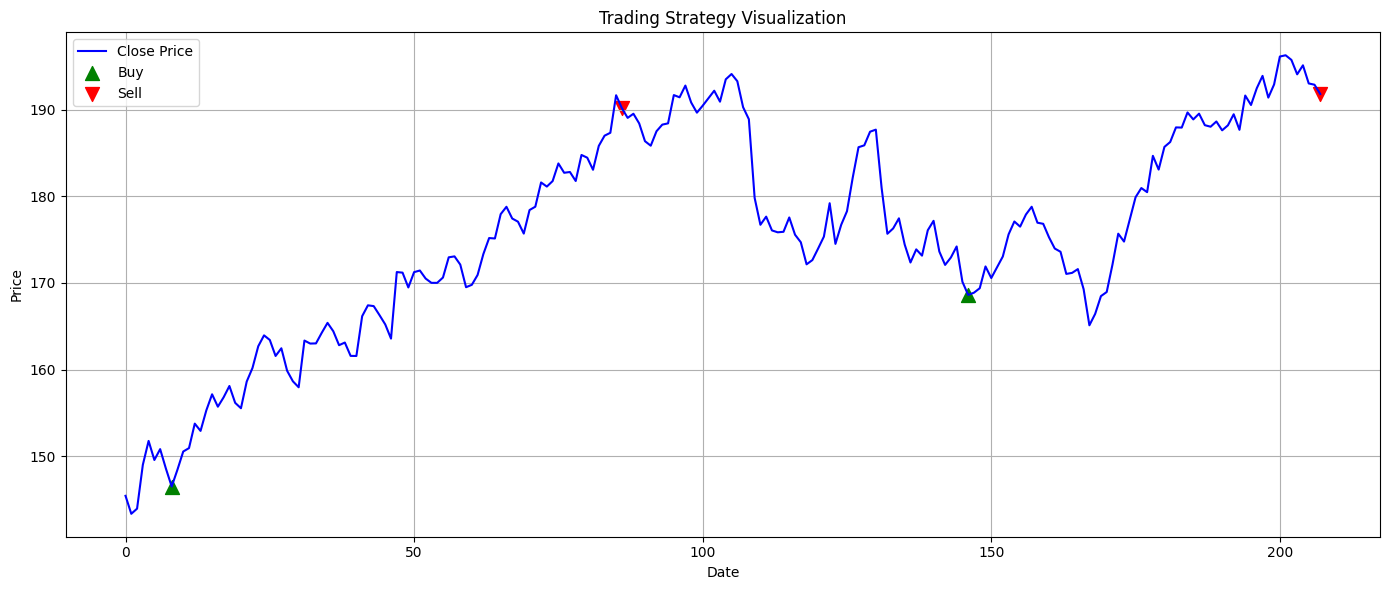

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# 初始化參數
initial_cash = 1000000
in_position = False
entry_price = 0
shares = 0
cash = initial_cash

# 儲存交易點資訊
buy_dates = []
buy_prices = []
sell_dates = []
sell_prices = []

# 手續費和稅率
fee_rate = 0.001425  # 手續費率 (1.425‰)
tax_rate = 0.0015     # 證券交易稅率 (1.5‰)
need_pay = 0 #需要付的手續費+稅金

# 模擬交易
for i in range(1, len(btdf)):
    if not in_position:
        need_pay = 0
        if btdf.loc[i, 'predicted_close'] > btdf.loc[i - 1, 'close']:
            entry_price = btdf.loc[i, 'close']
            shares = cash // entry_price
            need_pay += cash * fee_rate
            cash -= shares * entry_price
            in_position = True

            buy_dates.append(btdf.index[i])
            buy_prices.append(entry_price)

            print('買入價格:', entry_price)

    else:
        if btdf.loc[i, 'rsi'] > 76.032 and btdf.loc[i, 'predicted_close'] < btdf.loc[i - 1, 'close']:
            exit_price = btdf.loc[i, 'close']
            cash += shares * exit_price
            need_pay += cash * (fee_rate + tax_rate)
            shares = 0
            in_position = False

            sell_dates.append(btdf.index[i])
            sell_prices.append(exit_price)

            print('賣出價格:', exit_price)
            print('cash:', cash)
            print('額外要扣掉:', need_pay)
            cash -= need_pay
            print('扣掉後的:', cash)
            print('-------------------------------------')

# 最後一天強制平倉
if in_position:
    final_price = btdf.loc[len(btdf) - 1, 'close']
    cash += shares * final_price
    sell_dates.append(btdf.index[-1])
    sell_prices.append(final_price)
    print('賣出價格:', final_price)

# 顯示最終資金
print('最終價格:', cash)

# 繪圖
plt.figure(figsize=(14, 6))
plt.plot(btdf.index, btdf['close'], label='Close Price', color='blue')

# 標記買進與賣出點
plt.scatter(buy_dates, buy_prices, color='green', label='Buy', marker='^', s=100)
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

plt.title('Trading Strategy Visualization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
def preprocess(data_trend, train_ratio, n_past, predict_day):     
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day, 0])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data2 = df[[c for c in df.columns if c not in ['Date','Volume']]].values
X_train, Y_train, X_val, Y_val, X_test, Y_test = preprocess(data2, train_ratio, n_past, predict_day)
Y_test.shape

torch.Size([208, 5])

In [17]:
print(Y_test.shape)
pred_arr = []
#len(test_set)
arr = []
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device))
    pred = pred.detach().cpu().numpy()
    pred = pred.reshape(-1, 1)
    pred = np.repeat(pred, 4, axis=1)
    # print(pred)
    pred_inver = scaler.inverse_transform(pred)
    # print(pred_inver[:, 3])
    pred_arr.append(pred_inver[:, 0])
pred_arr = np.array(pred_arr)
pred_arr = torch.tensor(pred_arr)


torch.Size([208, 5])


In [18]:
print(pred_arr.shape)
mae = torch.mean(torch.abs(pred_arr - Y_test))
mape = torch.mean(torch.abs(pred_arr - Y_test)/Y_test)
# 新增：RMSE
rmse = np.sqrt(np.mean((np.array(close_price_true) - np.array(close_price_pred)) ** 2))
# 新增：R²
r2 = r2_score(close_price_true, close_price_pred)
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R²:   {r2:.4f}")

torch.Size([208, 5])
MAE:  4.6100
RMSE: 5.0226
MAPE: 2.5604%
R²:   0.8346


In [ ]:
import csv

with open('output/aapl_output.csv', mode='r', newline='') as file:
    reader = csv.reader(file)
    rows = list(reader)

for i in range(len(pred_arr[:,0])):
    rows[i].append(pred_arr[:,0][i].item())

# 寫回檔案
with open('output/aapl_output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)




In [20]:

mae = torch.mean(torch.abs(pred_arr[:,4] - Y_test[:,4]))
mape = torch.mean(torch.abs(pred_arr[:,4] - Y_test[:,4])/Y_test[:,4])
print(f"mae: {mae.item()}")
print(f"mape: {mape.item()}")

mae: 4.810502052307129
mape: 0.026874899864196777
